	#========================================================================
	# Copyright 2019 Science Technology Facilities Council
	# Copyright 2019 University of Manchester
	#
	# This work is part of the Core Imaging Library developed by Science Technology
	# Facilities Council and University of Manchester
	#
	# Licensed under the Apache License, Version 2.0 (the "License");
	# you may not use this file except in compliance with the License.
	# You may obtain a copy of the License at
	#
	#         http://www.apache.org/licenses/LICENSE-2.0.txt

	#
	# Unless required by applicable law or agreed to in writing, software
	# distributed under the License is distributed on an "AS IS" BASIS,
	# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
	# See the License for the specific language governing permissions and
	# limitations under the License.
	#
	#=========================================================================

<h1><center>Multi-Channel Reconstruction</center></h1>

Conventional X-ray detectors only measure the variable density of objects they pass through, giving no insight into what materials are actually inside. This is because standard detectors measure only the number of photons that arrive at each point on the detector.

For multi-channel imaging, one can use an energy-sensitive X-ray detector, which measures the energy of every X-ray photon that arrives at each individual pixel. This provides an additional layer of information which can provide important insight on a sample's composition or structure. However, adapted reconstruction routines are required to account for the extra energy-based dimension.

The additional energy dimension is stored as a histogram of energy 'channels', indicating the number of X-ray photons detected by a pixel within a fine energy range. Typically 200+ channels are acquired, however in order to speed up computation time, we will restrict our dataset to just 40 channels, where the dominant energy signals are known to appear.


**To Do** : Discuss any prerequisites/preliminary knowledge (CGLS, PDHG, Block...)

<h2><center>Learning Objectives</center></h2>

By the end of this notebook, you will be able to:

- Identify the key differences in building Image/Acquisition Geometries and Operators for multi-channel datasets 
- Construct your own reconstructions using both CGLS and PDHG
- Determine optimum regularisation parameters based on reconstruction method
- Evaluate the effectiveness of each reconstruction routine using energy profiles and elemental maps.
    
  

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utilities import islicer, link_islicer
from utilities.show_utilities import channel_to_energy, show

from ccpi.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

import numpy as np                 
import matplotlib.pyplot as plt
import h5py

from ccpi.optimisation.algorithms import PDHG, CGLS

from ccpi.optimisation.operators import BlockOperator, Gradient
from ccpi.optimisation.functions import L2NormSquared, KullbackLeibler,\
                                MixedL21Norm, BlockFunction, IndicatorBox

from ccpi.astra.processors import FBP
from ccpi.astra.operators import AstraProjectorMC, AstraProjector3DMC

In [2]:
#Read Data

pathname = '/media/newhd/shared/DataProcessed/Data_Ryan_Chris/reconstruction/'
filename = 'sinogram_centered_channels100_140.h5'

path = pathname + filename
arrays = {}
f = h5py.File(path, 'r+')
for k, v in f.items():
    arrays[k] = np.array(v)
X = arrays['SC']  

# We need to threshold neg values, otherwise KL fidelity is not well defined 
#X[X<0]=0

f.close()

The sample we will look at in this notebook is an iodine-stained lizard head. The use of elemental staining is common in biology and medicine, by acting as a contrast agent to provide improved visibility of internal structures for X-ray imaging. Iodine is a popular choice in the clinical and research fields, due to its energy-based properties falling in the typical range for diagnostic X-ray imaging.

The sample was scanned in a lab-based X-ray CT system at 50keV, 0.8W, using an energy-sensitive detector to acquire a full 4D dataset. The detector consisted of an 80 x 80 pixel array, with pixel sizes of 250 $\mu$m x 250 $\mu$m. A source-sample distance of 233.0 mm and a sample-detector distance of 245.0 mm gave a geometric magnification of 1.76x. The sample was scanned for 60 projections over a full 360$^{\circ}$ rotation, with 60s exposure time per projection.

<h1><center>Setting up Acquisition/Image Geometry</center></h1>

First we need to setup the geometries based on the acquisition system.
These are currently ordered based on the 4D raw dataset.

Run the code to see the current dimensions.

In [3]:
print(X.shape)

(40, 80, 60, 80)


We can allocate these separately

In [4]:
num_channels = X.shape[0]
num_pixels_h = X.shape[3]
num_pixels_v = X.shape[1]
num_angles = X.shape[2]

We set the angles used based on the parameters chosen for data acquisition. An offset is also applied (this just gives us the freedom to adjust the rotation of our reconstructed images).

In [5]:
angles = np.linspace(-180-55,180-55,num_angles,endpoint=False)*np.pi/180

We encode all this information into `AcquisitionGeometry` and `ImageGeometry`

In [6]:
# Define acquisition geometry from the detector system acquisition settings
# with reordering of the dimension labels to match the raw data

distance_source_center = 233.0  # [mm]
distance_center_detector = 245.0  # [mm]
detector_pixel_size = 0.25  # [mm]

ag = AcquisitionGeometry('cone',
                         '3D',
                         angles,
                         pixel_num_h=num_pixels_h,
                         pixel_size_h=detector_pixel_size,
                         pixel_num_v=num_pixels_v,
                         pixel_size_v=detector_pixel_size,                            
                         dist_source_center=distance_source_center, 
                         dist_center_detector=distance_center_detector,
                         channels=num_channels,
                         dimension_labels = ['channel', 'vertical', 'angle', 'horizontal'])

# Create the 4D acquisition data
data = AcquisitionData(X, geometry = ag, dimension_labels = ['channel', 'vertical', 'angle', 'horizontal'] )

# Calculate the geometric magnification to scale the voxel size relative
# to the detector pixel size.
mag = (ag.dist_source_center + ag.dist_center_detector)/ag.dist_source_center

# Define Image Geoemtry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h, 
                     voxel_num_y=ag.pixel_num_h,
                     voxel_num_z=ag.pixel_num_h,
                     voxel_size_x=ag.pixel_size_h/mag, 
                     voxel_size_y=ag.pixel_size_h/mag, 
                     voxel_size_z=ag.pixel_size_h/mag, 
                     channels=num_channels)

We can use an interactive image slicer `islicer` to provide a visualisation of the `AcquisitionData` in any dimension below. Simply by taking a data subset in a particular dimension, we can then visualise the data in any other given dimension.

Run the code below to see three such examples:

1) Projection radiographs for each of the 60 rotation angles acquired in a single channel

2) The sinogram for each energy channel for the central slice subset

3) The spectral signals acquired in each energy channel for a single projection angle

In [7]:
islicer(data.subset(channel=20), direction='angle', title = 'Projection Angle', cmap='inferno')
islicer(data.subset(vertical=40), direction='channel', title = 'Sinogram Channel', cmap='inferno')
islicer(data.subset(angle=40), direction='channel', title = 'Channel', cmap='inferno')

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=59), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

Setup the tomography operator for 3D multi-channel data using the `AcquisitionGeometry` and `ImageGeometry`

In [8]:
A3DMC = AstraProjector3DMC(ig, ag)

# FDK Reconstruction

One of the simplest, and most common, means of image reconstruction for X-ray CT is the use of Filtered BackProjection (FBP). In the case of many lab-based X-ray sources, which utilise a cone-beam rather than parallel- or fan-beams, we use a specific case of FBP: The Feldkamp-Davis-Kress (FDK) algorithm.

The function `FBP` is capable of handling reconstructions for both parallel-beam and cone-beam geometries in 2D and 3D.
Run the code below to see a reconstruction using the FDK algorithm.  Here we use a `ram-lak` filter as part of the reconstruction.

In [9]:
# Setup geometry for FDK
fdk = FBP(ig, ag, 'ram-lak') 
# Provide dataset
fdk.set_input(data)
# Store results
recon = fdk.get_output()
# Check dimensions
recon.shape

(40, 80, 80, 80)

In [10]:
recon.dimension_labels

{0: 'channel', 1: 'vertical', 2: 'horizontal_y', 3: 'horizontal_x'}

We can see we now have three spatial dimensions to our reconstructed data (each of size 80), along with our 40 energy channels. By selecting a single slice of a spatial dimension, we can view the resulting 80x80 reconstructed image for each energy channel using `islicer`.

In [11]:
# Show results
islicer(recon.subset(vertical=40),direction='channel',title='FDK: Channel', cmap='inferno', minmax=(0.0,0.4))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

While some features of the lizard head can be seen in the reconstructed images, much of the signal is shrouded by noise.  
In the next section, we will explore the first iterative algorithm - CGLS.

## Running the CGLS algorithm on a 4D dataset

As the next step, we will begin with a standard CGLS algorithm, applied to our 4D dataset

We initialise the operator based on the dimensions of the 4D dataset

Let's test the CGLS algorithm for just 10 iterations

In [34]:
# We initialise 
x_init = A3DMC.volume_geometry.allocate()

# Run the CGLS for 10 iterations
cgls = CGLS(x_init = x_init, operator = A3DMC, data = data, max_iteration = 100)
cgls.run(10)

CGLS set_up called from creator
Stop cryterion has been reached.
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0          0         0.000          3.69934e+06


We can use custom-made functions to visualise the quality of our reconstructions. Here we are looking at three commonly used views of the reconstructed dataset (axial, coronal and sagittal), and how these vary for different energy channels.

Run the code below to see reconstructions for the 10th, 20th and 30th energy channel in our truncated dataset, with the X-ray energies these correspond to.

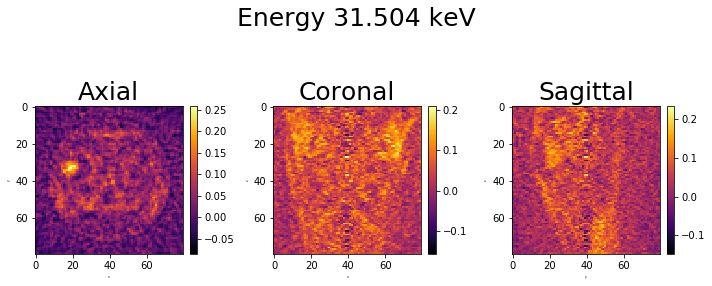

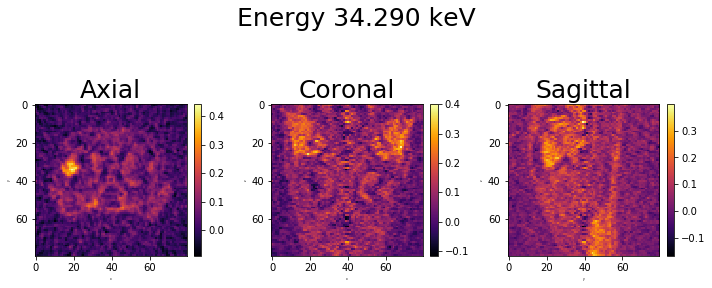

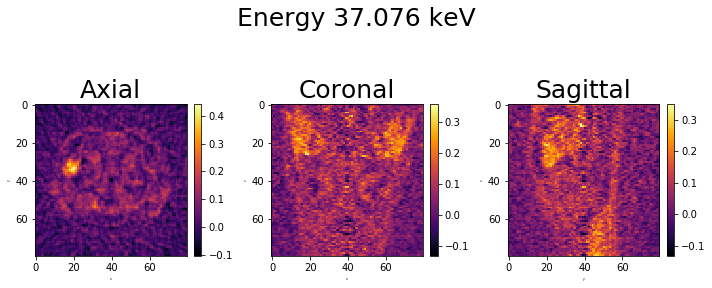

In [29]:
# Plot axial, coronal and sagittal views
# Plotter automatically converts channel number to energy
show(cgls.get_output(), show_channels=10, cmap='inferno', font_size=[25,3]) 
show(cgls.get_output(), show_channels=20, cmap='inferno', font_size=[25,3]) 
show(cgls.get_output(), show_channels=30, cmap='inferno', font_size=[25,3]) 

As a result of performing our reconstruction, we change the shaope and dimensions of our 4D dataset, as we now have 3 spatial dimensions along with the energy channels.
Run the following code to see the new shape and corresponding dimension labels.

In [30]:
print('Shape = ', cgls.get_output().shape)
print('Labels = ', cgls.get_output().dimension_labels)

Shape =  (40, 80, 80, 80)
Labels =  {0: 'channel', 1: 'vertical', 2: 'horizontal_y', 3: 'horizontal_x'}


You can use these labels to once more explore visualisations with the islicer function. Try varying the subset dimension and the direction using the label names above.

In [31]:
# Choose a subset dimension and value, and the direction you want to slice along

#islicer(cgls.get_output().subset(LABEL/VALUE HERE),direction='LABEL HERE',title='TITLE HERE')

In [32]:
# Examples for scrolling through channels in each view
sl1 = islicer(cgls.get_output().subset(vertical=40),direction='channel',title='Axial: Channel', cmap='inferno', minmax = (0.0,0.4))
sl2 = islicer(cgls.get_output().subset(horizontal_y=40),direction='channel',title='Coronal: Channel', cmap='inferno', minmax = (0.0,0.4))
sl3 = islicer(cgls.get_output().subset(horizontal_x=40),direction='channel',title='Sagittal: Channel', cmap='inferno', minmax = (0.0,0.4))
link_islicer(sl1,sl2,sl3)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

Now we can see how the visualisation changes if we increase the number of iterations. We can also use the  `callback` function as we increase iterations, providing a reconstructed image slice with each objective interval.

CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          3.69934e+06
       10        100         0.950          2.95275e+05


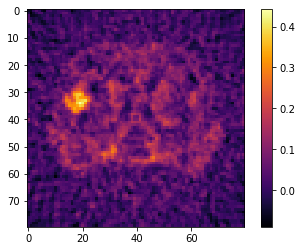

       20        100         0.963          7.01499e+04


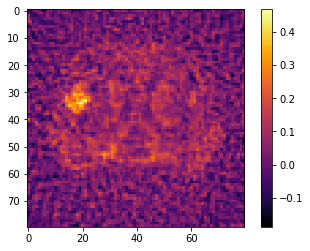

       30        100         0.972          6.13016e+04


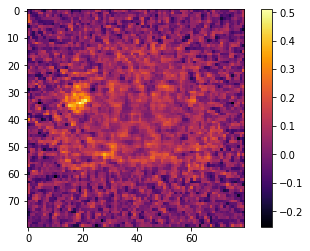

In [18]:
# Initialise 
x_init = A3DMC.volume_geometry.allocate()

# Run the CGLS for 30 iterations
cgls2 = CGLS(x_init = x_init, operator = A3DMC, data = data)
cgls2.max_iteration = 100
cgls2.update_objective_interval = 10
cgls2.run(30, verbose = True, callback = show_data_4D)

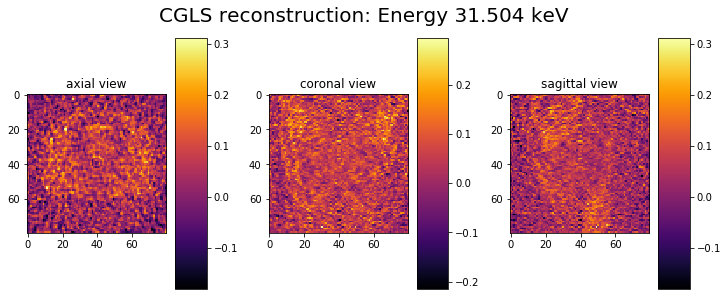

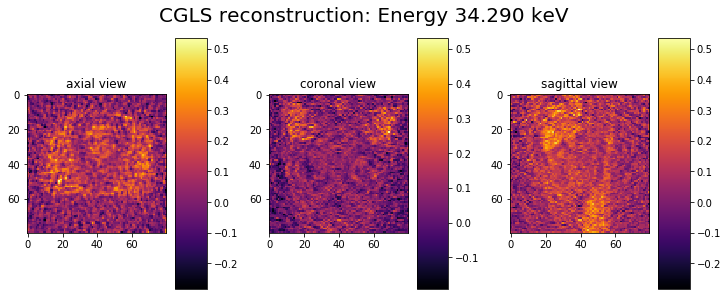

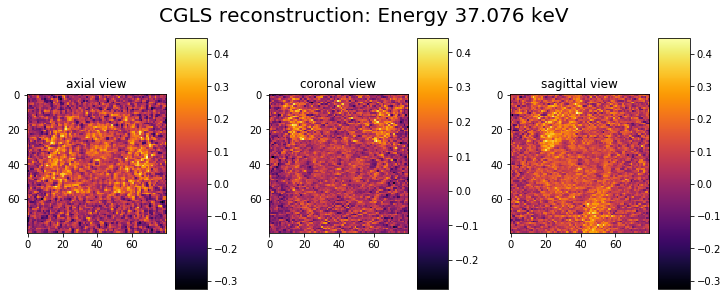

In [19]:
# Plot axial, coronal and sagittal views
# Note: Could swap this every time for islicer
show_4D_channel_slice(cgls2.get_output(), 10, 'CGLS reconstruction') 
show_4D_channel_slice(cgls2.get_output(), 20, 'CGLS reconstruction') 
show_4D_channel_slice(cgls2.get_output(), 30, 'CGLS reconstruction') 

These images highlight the instability of a basic CGLS algorithm, with a larger number of iterations leading to a divergence from an optimum solution, resulting in a noisier image compared to just 10 iterations.

In the next section, we will look at a different algorithm: Primal-Dual Hybrid Gradient (PDHG), combined with a Total Variation (TV) regularising factor, to see if this improves our reconstructed data quality.

## Total Variation Reconstruction in 4D Volume using PDHG

**To Do:** (Show the initial problem we want to solve)
Remind the user about PDHG formulation for TV
(Show how we reduce the problem)

First we define the functions $f$ and $g$, and the linear operator, $K$

$K$ is a `BlockOperator` that contains the gradient, $\nabla$ and the tomography operator, $A$

Therefore we have
$$ K = 
\begin{bmatrix}
A \\
\nabla
\end{bmatrix} $$

In [20]:
# The operator K is a Block Operator that contains the gradient and the tomography operator 
op1 = A3DMC
op2 = Gradient(ig)

# Set up a BlockOperator
operator = BlockOperator(op1, op2, shape=(2,1)) 


$f$ is a block function of a fidelity term and a mixed $L_{21}$ norm. Here the fidelity is an $L^{2}_{2}$ term:


$$ f(x_{1}, x_{2}) = (\frac{1}{2} \| x_{1} - g \|_{2}^{2} , \| x_{2} \| _{2,1} ) = (f_{1}, f_{2})$$

where $x_{1}$ is `AcquisitionData` i.e., belongs to `AcquisitionGeometry` 
and $x_{2}$ is a `BlockDataContainer`.

Then $$ f(Ku) = f(
\begin{bmatrix}
A u \\
\nabla u
\end{bmatrix}) = ( f_{1}(Au), f_{2}(\nabla u) ) $$

In [21]:
alpha = 0.05
f1 = 0.5 * L2NormSquared(b = data)    
f2 = alpha * MixedL21Norm()

f = BlockFunction(f1, f2) 

In [22]:
#g is an indicator function that provides a positivity constraint
g = IndicatorBox(lower = 0)

#Now we compute the operator norm for K
normK = operator.norm()

#Then we define the step sizes sigma and tau
sigma = 1
tau = 1/(sigma*normK**2)  

Now we run the PDHG

PDHG set_up called from creator
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.84967e+06  -0.00000e+00    1.84967e+06
       25       1000         2.231    7.22022e+05  -2.99306e+07    3.06527e+07


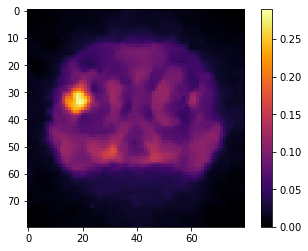

       50       1000         2.128    5.89451e+04  -1.09716e+05    1.68661e+05


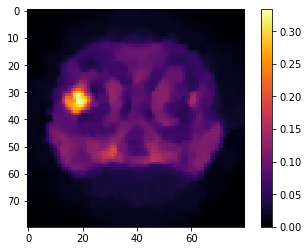

       75       1000         2.115    5.74375e+04  -1.99257e+03    5.94301e+04


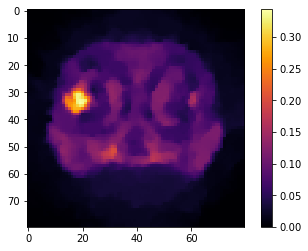

      100       1000         2.112    5.71680e+04   2.89910e+04    2.81769e+04


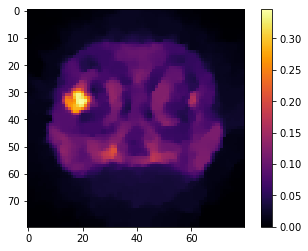

In [23]:
pdhg = PDHG(f = f, g = g, operator = operator, tau = tau, sigma = sigma)
pdhg.max_iteration = 1000
pdhg.update_objective_interval = 25
pdhg.run(100, verbose = True, callback = show_data_4D)

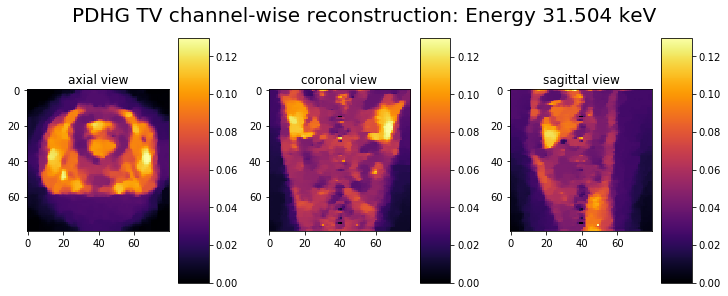

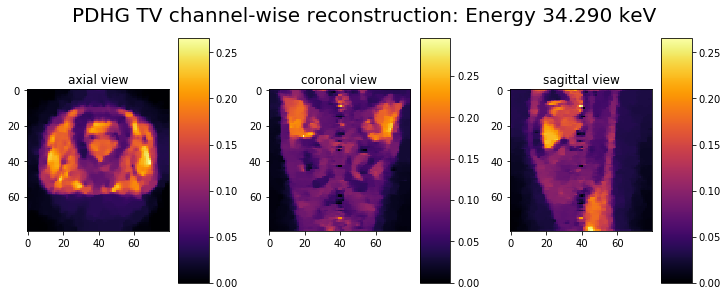

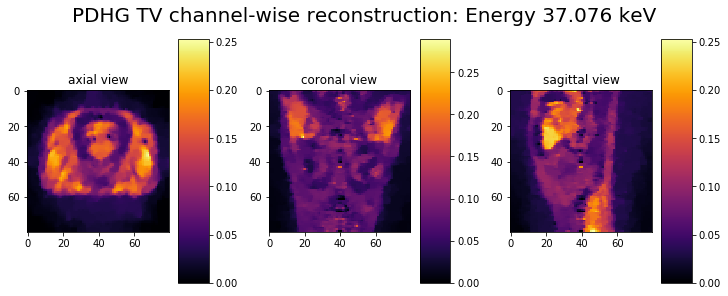

In [24]:
show_4D_channel_slice(pdhg.get_output(), 10, 'PDHG TV channel-wise reconstruction') 
show_4D_channel_slice(pdhg.get_output(), 20, 'PDHG TV channel-wise reconstruction') 
show_4D_channel_slice(pdhg.get_output(), 30, 'PDHG TV channel-wise reconstruction') 

In [25]:
#Examples for scrolling through channels in each view
islicer(pdhg.get_output().subset(vertical=40),direction='channel',title='Axial: Channel', cmap='inferno', minmax = (0.0,0.3))
islicer(pdhg.get_output().subset(horizontal_y=40),direction='channel',title='Coronal: Channel', cmap='inferno', minmax = (0.0,0.3))
islicer(pdhg.get_output().subset(horizontal_x=40),direction='channel',title='Sagittal: Channel', cmap='inferno', minmax = (0.0,0.3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

## Exercise 1: Change correlation to Space-Channel, fidelity to Kullback-Leibler

We can make some adjustments to our framework to see how these affect the reconstruction.

First try changing the gradient component of our operator, $\nabla$, so that it is correlated in both the spatial and energy channel domain. Keep the tomography operator, $A$ the same.

Next change the fidelity term of our Block function, $f_{1}$ to instead use Kullback-Leibler. Keep the second term, $f_{2}$ as a mixed $L_{21}$ norm.

Note: 
- There are three other key parameters that have an impact on the resulting reconstruction: alpha, sigma and tau. For our original PDHG reconstruction, these optimum parameters were $\alpha$ = 0.05, $\sigma$ = 1, $\tau$ = 1/$\sigma||K||^{2}$ .

Do these need to be changed with our new setup? Run the reconstruction with the original values and then try adjusting each of these to see what effect they have.
(Don't forget that $\tau\sigma||K||^{2} < 1$)


In [26]:
# Adjust the correlation of the gradient operator

#op2 = Gradient(ig, correlation = "ANSWER HERE")

# Construct new BlockOperator

#operator = ANSWER HERE

# Compute the operator norm for K

#normK = ANSWER HERE

# Define regularising parameter alpha

#alpha = VALUE HERE

# Define the step sizes sigma and tau

#sigma = VALUE HERE
#tau = ANSWER HERE

# Change fidelity term f1

#f1 = ANSWER HERE
#f2 = alpha * MixedL21Norm()

# Construct new BlockFunction

#f = ANSWER HERE

In [27]:
op2 = Gradient(ig, correlation = "SpaceChannels")

operator = BlockOperator(op1, op2, shape=(2,1) ) 

alpha = 0.07
#Now we compute the operator norm for K
normK = operator.norm()

#Then we define the step sizes sigma and tau
sigma = 1
tau = 1/(sigma*normK**2) 

f1 = KullbackLeibler(data)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

Once you've made these changes, have a go at running the reconstruction and see what influence these changes had visually.

PDHG set_up called from creator
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    0.00000e+00  -0.00000e+00    0.00000e+00
       25       1000         2.718    1.23837e+06  -4.25831e+07    4.38215e+07


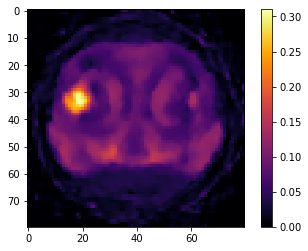

       50       1000         2.629    1.96879e+05  -1.20825e+04    2.08962e+05


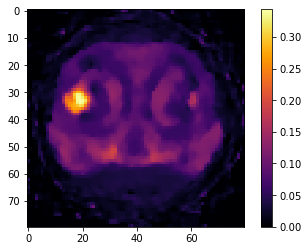

       75       1000         2.614    1.92586e+05   1.41837e+05    5.07495e+04


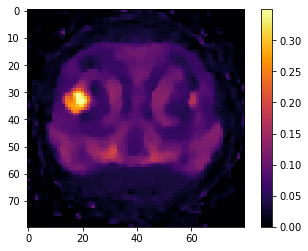

      100       1000         2.604    1.91771e+05   1.75038e+05    1.67331e+04


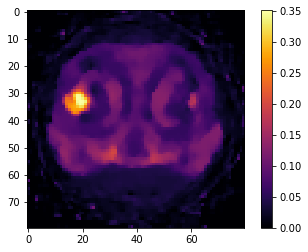

In [28]:
pdhg_KL = PDHG(f = f, g = g, operator = operator, tau = tau, sigma = sigma)
pdhg_KL.max_iteration = 1000
pdhg_KL.update_objective_interval = 25
pdhg_KL.run(100, verbose = True, callback = show_data_4D)


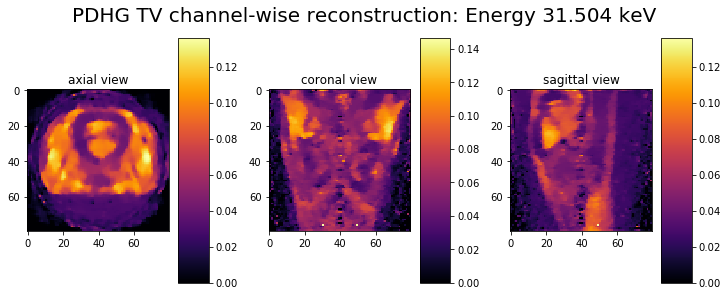

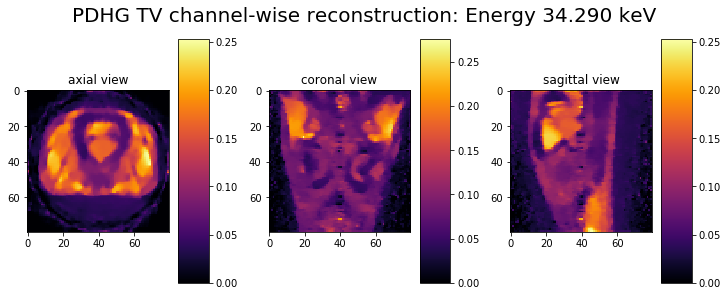

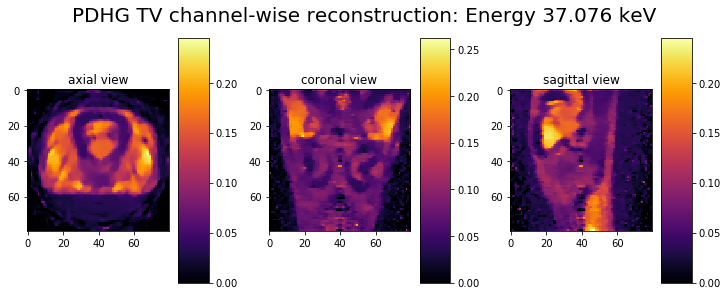

In [29]:
show_4D_channel_slice(pdhg_KL.get_output(), 10, 'PDHG TV channel-wise reconstruction') 
show_4D_channel_slice(pdhg_KL.get_output(), 20, 'PDHG TV channel-wise reconstruction') 
show_4D_channel_slice(pdhg_KL.get_output(), 30, 'PDHG TV channel-wise reconstruction') 

In [30]:
#Examples for scrolling through channels in each view
islicer(pdhg_KL.get_output().subset(vertical=40),direction='channel',title='Axial: Channel',cmap='inferno', minmax = (0.0,0.3))
islicer(pdhg_KL.get_output().subset(horizontal_y=40),direction='channel',title='Coronal: Channel', cmap='inferno', minmax = (0.0,0.3))
islicer(pdhg_KL.get_output().subset(horizontal_x=40),direction='channel',title='Sagittal: Channel', cmap='inferno', minmax = (0.0,0.3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

We can directly compare the two types of PDHG reconstruction using `islicer`. As we move across energy channels, see if you can notice any major differences between the constructions:  
1) PDHG TV using an $L^{2}_{2}$ fidelity and Spatial correlation  
2) PDHG TV using Kullback-Leibler fidelity and Space-Channel correlation

In [64]:
i1 = islicer(pdhg.get_output().subset(vertical=40),direction='channel',title='L2Norm: Channel', cmap='inferno', minmax = (0.0,0.3))
i2 = islicer(pdhg_KL.get_output().subset(vertical=40),direction='channel',title='KL: Channel',cmap='inferno', minmax = (0.0,0.3))
link_islicer(i1,i2)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

## Exercise 2: Move to 2D Spatial Geometry with Channels
## Defining 2D `Acquisition/Image Geometry` and `Projector`

From our 4D dataset, we can reduce the dimensionality by taking a single slice along a particular spatial dimension. 
We can go from a shape of 

                (Channel, Vertical, Angle, Horizontal) = (40, 80, 60, 80)  
to a shape of 

                        (Channel, Angle, Horizontal) = (40, 60, 80)  
by taking a vertical slice subset.



As we transition to a reduced dataset, however, we must redefine both our `AcquisitionGeometry` and `ImageGeometry`.  
First we redefine the angles.

In [116]:
angles = np.linspace(-180+122,180+122,num_angles,endpoint=False)*np.pi/180

Based on the parameters we used for the 4D dataset, try to redefine the `AcquisitionGeometry` and `ImageGeometry` for our reduced dataset, where we now have two spatial dimensions, and one energy dimension.

Hint: If you can't remember the required inputs for Acquisition or Image Geometry, you can see what we used for the 4D setup by typing the following
   - AcquisitionGeometry??
   - ImageGeometry??  
   
and running the code.

**ToDo: Tag back to cells defining ag/ig**

In [82]:
# Setup the AcquisitionGeometry for 2D plus channels

#ag2d = ANSWER HERE

# Setup the ImageGeometry for 2D plus channels

#ig2d = ANSWER HERE

In [97]:
ag2d = AcquisitionGeometry('cone',
                         '2D',
                         angles,
                         pixel_num_h=num_pixels_h,
                         pixel_size_h=detector_pixel_size,                            
                         dist_source_center=distance_source_center, 
                         dist_center_detector=distance_center_detector,
                         channels=num_channels)

ig2d = ImageGeometry(voxel_num_x=ig.voxel_num_x,
                     voxel_num_y=ig.voxel_num_y,
                     voxel_size_x=ag2d.pixel_size_h/mag,
                     voxel_size_y=ag2d.pixel_size_h/mag,
                     channels = ig.channels)

Now we can setup the tomography operator for 2D multi-channel data using the redefined `AcquisitionGeometry` and `ImageGeometry` for 2D. Let's call it `A2DMC`. 

(Remember: Last time we used `AstraProjector3DMC` as we had a 3D multi-channel dataset.)

In [98]:
# Setup the tomography operator for 2D plus channels

#A2DMC = ANSWER HERE

In [99]:
A2DMC = AstraProjectorMC(ig2d, ag2d, 'cpu')

Finally, reduce the dataset to a 2D multi-channel set by taking a single slice of the original `AcquisitionData`.  
For simplicity, choose a central slice subset by setting ' vertical=40 '.

In [100]:
# Take a central slice of the AcquisitionData

#data2DMC = ANSWER HERE

In [101]:
data2DMC = data.subset(vertical=40)

## Exercise 3: Running 2D plus channel CGLS

In this exercise, use what you've learned about setting up reconstruction routines, and perform a simple CGLS using our 2D multi-channel data. Then run it for 10 iterations.

(Remember: The key parameters you need are your initialisation (x_init), operator and data)

In [102]:
# Initialise the tomography operator

#x_init = ANSWER HERE

In [103]:
# Setup the algorithm

#cgls2d = CGLS(ANSWER HERE)
#cgls2d.max_iteration = ANSWER HERE

# Run the algorithm

#cgls2d.run(ANSWER HERE)

In [104]:
x_init = A2DMC.volume_geometry.allocate()

cgls2d = CGLS(x_init = x_init, operator = A2DMC, data = data2DMC)
cgls2d.max_iteration = 100
cgls2d.run(10, verbose = True)


CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          3.84376e+04
        1        100         0.000          3.07685e+03
        2        100         0.303          1.56080e+03
        3        100         0.304          1.22449e+03
        4        100         0.312          1.07871e+03
        5        100         0.302          9.56438e+02
        6        100         0.302          8.97023e+02
        7        100         0.307          8.65808e+02
        8        100         0.309          8.53988e+02
        9        100         0.299          8.18728e+02
       10        100         0.307          7.93857e+02


You can check the results of your reconstruction by running the function `show_2D_channel` below, giving you axial views for three energy channels.

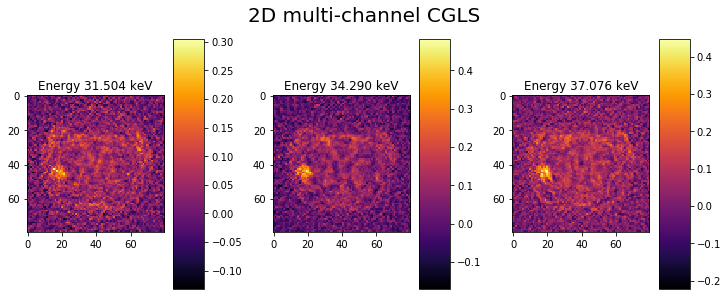

In [105]:
# Show reconstruction 
show_2D_channel(cgls2d.get_output(), [10,20,30], '2D multi-channel CGLS')

In [106]:
islicer(cgls2d.get_output(),direction='channel',title='Channel',cmap='inferno',minmax=(0.0,0.3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

## Exercise 4: Running 2D plus channel regularised CGLS

Here we will expand upon what you learned about BlockFrameworks. 

**To Do:** 
 - Recap of BlockFrameworks (including reference back to appropriate notebook)

Using the 2D multi-channel data and geometry constructed above, build a `BlockOperator`, $A$, applying a Space-Channel correlation.  
Next use our reduced `AcquisitionData` to build a `BlockDataContainer`.  
Finally initialise the `BlockOperator` and run the algorithm for 50 iterations.

In [107]:
# Set up operators for BlockOperator

#op1 = ANSWER HERE
#op2 = ANSWER HERE
#alpha = VALUE HERE
#A_block = BlockOperator(ANSWER HERE)

# Create BlockDataContainer

#g_block = BlockDataContainer(ANSWER HERE)

In [108]:
# Setup and run the regularised CGLS algorithm

#cgls_reg = CGLS(ANSWER HERE)
#cgls_reg.max_iteration = ANSWER HERE

# Run the algorithm for 50 iterations

#cgls_reg.run(ANSWER HERE)

In [109]:
op1 = Gradient(ig2d)
op2 = A2DMC
alpha = 1.5
A_tilde = BlockOperator(alpha*op1,op2)
g_tilde = BlockDataContainer(op1.range_geometry().allocate(),data2DMC)

x_init = A_tilde.domain_geometry().allocate()

In [110]:
cgls_reg = CGLS(x_init = x_init, operator = A_tilde, data = g_tilde)
cgls_reg.max_iteration = 100
cgls_reg.update_objective_interval = 10
cgls_reg.run(50, verbose = True)

CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          3.84376e+04
       10        100         0.254          3.08076e+03
       20        100         0.251          1.26949e+03
       28        100         0.255          1.26944e+03
Tolerance is reached: 1e-06


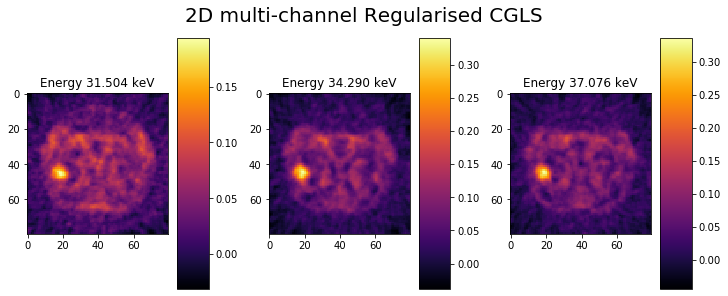

In [111]:
# Show reconstruction 
show_2D_channel(cgls_reg.get_output(), [10,20,30], '2D multi-channel Regularised CGLS')

In [112]:
islicer(cgls_reg.get_output(),direction='channel',title='Channel',cmap='inferno',minmax=(0.0,0.3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

## Exercise 5: 2D Multi-channel Total Variation with PDHG

Now let's test our reduced dataset with the PDHG algorithm using Total Variation regularisation.

Based on what our construction looked like for the 4D version, try to recreate this for our 2D multi-channel data. You'll need to adjust the `BlockOperator`, $K$ and `BlockFunction`, $f$.

Play around with the numeric parameters (alpha, sigma and tau) as well, and see how they affect the reconstruction here. Is there a big change when moving from 3D multi-channel to 2D multi-channel?

In [113]:
# Setup the BlockOperator, K

#op1 = ANSWER HERE
#op2 = ANSWER HERE
#operator = BlockOperator(ANSWER HERE)

# Setup the BlockFunction, f

#alpha = VALUE HERE
#f1 = ANSWER HERE
#f2 = ANSWER HERE
#f = BlockFunction(ANSWER HERE)

# Compute the operator norm for K

#normK = ANSWER HERE

# Define the step sizes sigma and tau

#sigma = VALUE HERE
#tau = ANSWER HERE

# Define indicator function that provides a positivity constraint

#g = ANSWER HERE

In [51]:
# Setup and run the PDHG algorithm

#pdhg_2d = PDHG(ANSWER HERE)
#pdhg_2d.max_iteration = VALUE HERE
#pdhg_2d.run(ANSWER HERE)

In [52]:
op1 = Gradient(ig2d, correlation='SpaceChannels')
op2 = A2DMC
operator = BlockOperator(op1,op2)

alpha = 0.04

normK = operator.norm()

sigma = 2
tau = 1/(sigma*normK**2) 

f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=data2DMC)
f = BlockFunction(f1,f2)

g = IndicatorBox(lower=0)

In [53]:
pdhg_2d = PDHG(f=f, g=g, operator=operator, tau=tau, sigma=sigma)
pdhg_2d.max_iteration = 1000
pdhg_2d.update_objective_interval = 25
pdhg_2d.run(100, verbose = True)

PDHG set_up called from creator
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.92188e+04  -0.00000e+00    1.92188e+04
       25       1000         0.108    1.06759e+04  -4.76586e+05    4.87262e+05
       50       1000         0.099    7.92590e+02  -3.57870e+03    4.37129e+03
       75       1000         0.098    7.35018e+02  -9.62581e+02    1.69760e+03
      100       1000         0.098    7.21716e+02  -2.14449e+02    9.36166e+02


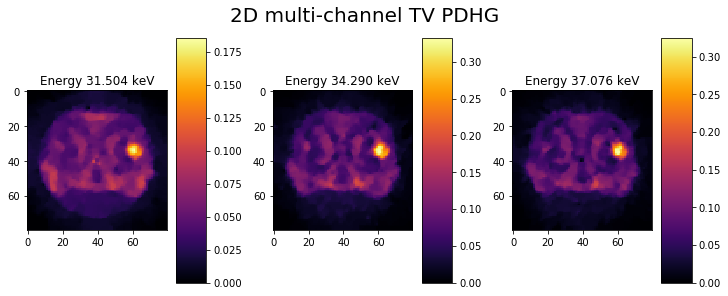

In [54]:
# Show reconstruction 
show_2D_channel(pdhg_2d.get_output(), [10,20,30], '2D multi-channel TV PDHG')

In [55]:
islicer(pdhg_2d.get_output(),direction='channel',title='Channel',cmap='inferno',minmax = (0.0,0.3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

## Extracting Energy-based profiles

Once we have chosen and optimised our reconstruction routine, we can exploit this additional, energy dimension further by identifying the spectral signals that lie within.

First we can plot out energy profiles for any region-of-interest in our reconstructed slices. This allows us to find, for instance, an absorption edge (caused by photoelectric absorption of X-ray photons by the iodine in our sample).
Iodine has a known absorption 'K-edge' of 33.169 keV, so we can test the accuracy of reconstruction algorithms by seeing where this edge falls in each case.

**To Do:** (Add picture of K-edge)

We start by extracting a 3x3 set of pixels from each of the 2D multi-channel datasets. We can choose the pixels with the highest signal by looking at our previous reconstructed images.


In [117]:
# Collect 3x3 regions of interest for each dataset

# 2d multi-channel simple CGLS
# Sum along y-direction
cgls2d_ROI1 = np.mean(cgls2d.get_output().as_array()[:,34:35,:],1)
# Sum along x-direction
cgls2d_ROI2 = np.mean(cgls2d_ROI1[:,60:62],1)

# 2d multi-channel regularised CGLS
cgls_reg_ROI1 = np.mean(cgls_reg.get_output().as_array()[:,34:35,:],1)
cgls_reg_ROI2 = np.mean(cgls_reg_ROI1[:,60:62],1)

# 2d multi-channel PDHG TV
pdhg_2d_ROI1 = np.mean(pdhg_2d.get_output().as_array()[:,34:35,:],1)
pdhg_2d_ROI2 = np.mean(pdhg_2d_ROI1[:,60:62],1)


Text(0.5, 0, 'Energy (keV)')

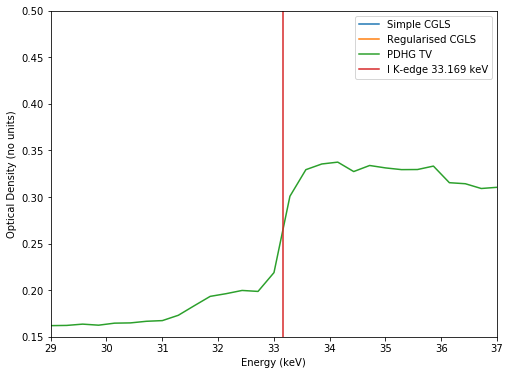

In [115]:
# Set channel numbers for reduced dataset
channel_no = np.linspace(100,140,num_channels)
# Apply linear calibration equation to convert channels to energy
e_keV = 0.2786*channel_no + 0.8575

plt.figure(figsize=(8,6))

plt.plot(e_keV,cgls2d_ROI2) 
plt.plot(e_keV,cgls_reg_ROI2)
plt.plot(e_keV,pdhg_2d_ROI2)

plt.plot((33.169,33.169),plt.ylim(0.15,0.5))

plt.legend(labels=['Simple CGLS', 'Regularised CGLS', 'PDHG TV', 'I K-edge 33.169 keV'])
plt.ylim(0.15,0.5)
plt.xlim([29,37])

plt.ylabel('Optical Density (no units)')
plt.xlabel('Energy (keV)')

From our plots, we can see all algorithms experience a sharp rise in signal value due to the iodine absorption K-edge. Compared to the theoretical value line, each of the cases match well with the expected position of the edge.
An important factor to note is the increased smoothness of the signal for both regularised CGLS and PDHG TV, compared to a simple CGLS reconstruction. This is due to applying a 'Space-Channel' correlation to our gradient operator for these methods.

Once we know have identified the position of this edge in our energy profile, we can narrow our dataset and produce an 'Iodine map'. That is, we can select only the energy channels occupied by the absorption edge, so all reconstructed signal is now due only to the iodine contrast agent.

Based on our plots, we will estimate the start and end of the edge to occur at approximately 32.75 keV and 33.75 keV respectively.

**ADD IMAGE OF K-EDGE SUBTRACTION CONCEPT**

In [58]:
# Calculate energy channels corresponding to start and end of the K-edge
e_keV = np.array([32.75,33.75])
channel_no = ((e_keV-0.8575)/0.2786)-100

# Display the channels corresponding to the start and end of the K-edge
print(channel_no)


[14.4741565  18.06353195]


In [59]:
# 2d multi-channel simple CGLS
# Sum over all pixels for channels of interest
cgls2d_COI = np.mean(cgls2d.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)

# 2d multi-channel regularised CGLS
cgls_reg_COI = np.mean(cgls_reg.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)

# 2d multi-channel PDHG TV
pdhg_2d_COI = np.mean(pdhg_2d.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)


(<matplotlib.image.AxesImage at 0x7fcaa1fe6a90>,
 Text(0.5, 1.0, 'Simple CGLS Iodine map'),
 <matplotlib.colorbar.Colorbar at 0x7fcaaee8b898>)

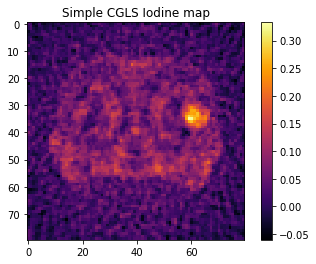

In [60]:
# Plot iodine maps for each reconstruction
plt.imshow(cgls2d_COI,cmap='inferno'), plt.title('Simple CGLS Iodine map'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fcaa13bf6a0>,
 Text(0.5, 1.0, 'Regularised CGLS Iodine map'),
 <matplotlib.colorbar.Colorbar at 0x7fcaaec81e10>)

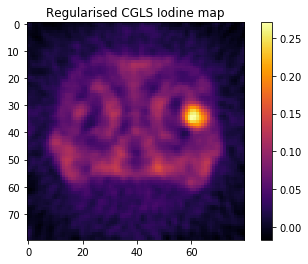

In [61]:
plt.imshow(cgls_reg_COI,cmap='inferno'), plt.title('Regularised CGLS Iodine map'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fca9a5696a0>,
 Text(0.5, 1.0, 'TV PDHG Iodine map'),
 <matplotlib.colorbar.Colorbar at 0x7fcaa1fa0b38>)

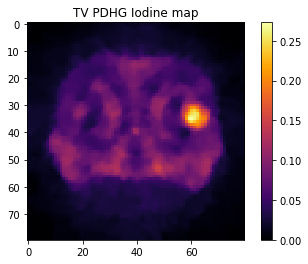

In [62]:
plt.imshow(pdhg_2d_COI,cmap='inferno'), plt.title('TV PDHG Iodine map'), plt.colorbar()

Finally we can bring together the 2D multi-channel reconstructions we have performed for:
 - Simple CGLS
 - Regularised CGLS
 - PDHG with TV  
 
Using the islicer tool, we can directly compare these reconstructions side-by-side and evaluate the level of noise removal and spatial/energy smoothing offered by each method.

In [63]:
s1 = islicer(cgls2d.get_output(), direction = 'channel', title = 'Simple CGLS: Channel',cmap='inferno',minmax = (0.0,0.3))
s2 = islicer(cgls_reg.get_output(), direction = 'channel', title = 'Regularised CGLS: Channel',cmap='inferno',minmax = (0.0,0.3))
s3 = islicer(pdhg_2d.get_output(), direction = 'channel', title = 'TV PDHG: Channel',cmap='inferno',minmax = (0.0,0.3))
link_islicer(s1,s2,s3)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

<h1><center>Conclusions</center></h1>

This notebook focused on bringing together the core elements of the CIL framework you have learned in the previous courses, and seeing how these may be applied to a multi-channel dataset. 

We looked at the key differences in building Image/Acquisition Geometries and Operators for multi-channel datasets, and how these vary for both 2D and 3D multi-channel.

We have covered two key algorithms (CGLS and PDHG) and shown the differences between these for both 2D and 3D multi-channel. This also allowed us to explore some of the ways in which we can vary these reconstruction routines, and how making these adjustments can have significant effects on the quality of your reconstructions.

Finally we have shown the ability to extract spectral properties from the reconstruction, providing an insight to the elemental composition of the sample of interest using energy profiles and elemental maps.